In [58]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=4
!nvidia-smi

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=4
Fri Nov 17 18:26:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:01:00.0 Off |                    0 |
| N/A   46C    P0    69W / 275W |      3MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM... 

In [3]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

In [4]:
import sys
import os
import getpass

os.chdir('/home/' + getpass.getuser() + '/Projects/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + '/Projects/CaloQVAE/')

In [5]:
#external libraries
import os
import pickle
import datetime
import sys
import yaml
import json

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

import time

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging

[19:33:14.655] INFO   CaloQVAE                                          Willkommen!
[19:33:14.655] INFO   CaloQVAE                                          Loading configuration.


In [6]:
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
HLF_1_photons = HLF('photon', filename='/raid/javier/Datasets/CaloVAE/data/atlas/binning_dataset_1_photons.xml', wandb=False)
HLF_1_pions = HLF('pion', filename='/raid/javier/Datasets/CaloVAE/data/atlas/binning_dataset_1_pions.xml', wandb=False)
HLF_1_electron = HLF('electron', filename='/raid/javier/Datasets/CaloVAE/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)

[19:33:15.163] INFO   numexpr.utils                                     Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
[19:33:15.163] INFO   numexpr.utils                                     Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[19:33:15.164] INFO   numexpr.utils                                     NumExpr defaulting to 8 threads.
2023-11-16 19:33:15,570 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[19:33:15.570] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0


In [7]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="configs")

hydra.initialize()

In [59]:


# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")
wandb.init(project="caloqvae", entity="qvae", config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

/raid/javier/anaconda3/lib/python3.11/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[18:27:34.621] INFO   data.dataManager                                  Loading Data
[18:27:40.419] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7facf8316d50>: 80000 events, 625 batches
[18:27:40.419] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7face09e8350>: 10000 events, 10 batches
[18:27:40.420] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7face092c850>: 10000 events, 10 batches
[18:27:42.510] INFO   models.modelCreator                               Initialising Model Type GumBoltAtlasPRBMCNN
2023-11-17 18:27:42

Initializing NetworkV3


In [60]:
#Not printing much useful info at the moment to avoid clutter. TODO optimise
model.print_model_info()
# for name, param in model.named_parameters():
#         print(name, param.requires_grad)

# Load the model on the GPU if applicable
# dev = None
# if (config.device == 'gpu') and config.gpu_list:
#     logger.info('Requesting GPUs. GPU list :' + str(config.gpu_list))
#     devids = ["cuda:{0}".format(x) for x in list(config.gpu_list)]
#     logger.info("Main GPU : " + devids[0])

#     if is_available():
#         print(devids[0])
#         dev = device(devids[0])
#         if len(devids) > 1:
#             logger.info(f"Using DataParallel on {devids}")
#             model = DataParallel(model, device_ids=list(config.gpu_list))
#         logger.info("CUDA available")
#     else:
#         dev = device('cpu')
#         logger.info("CUDA unavailable")
# else:
#     logger.info('Requested CPU or unable to use GPU. Setting CPU as device.')
#     dev = device('cpu')
dev = torch.device("cuda:0")

# Send the model to the selected device
# model.to(dev)
# Log metrics with wandb
wandb.watch(model)

# For some reason, need to use postional parameter cfg instead of named parameter
# with updated Hydra - used to work with named param but now is cfg=None 
engine=instantiate(config.engine, config)

#TODO for some reason hydra double instantiates the engine in a
#newer version if cfg=config is passed as an argument. This is a workaround.
#Find out why that is...
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

[18:27:46.395] INFO   models.autoencoders.autoencoderbase               _dataset_mean: torch.Size([1, 6480])
[18:27:46.395] INFO   wandb                                             Watching
[18:27:46.398] INFO   engine.engineAtlas                                Setting up engine Atlas.
[18:27:46.399] INFO   engine.engineCaloV3                               Setting up engine Calo.
[18:27:46.399] INFO   engine.engine                                     Setting up default engine.


In [61]:
# config=compose(config_name="config.yaml")
config_2=compose(config_name="config.yaml")
wandb.init(project="caloqvae", entity="qvae", config=config_2, mode='disabled')
modelCreator_2 = ModelCreator(cfg=config_2)
dataMgr_2 = DataManager(cfg=config_2)
#initialise data loaders
dataMgr_2.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr_2.pre_processing()

if config_2.model.activation_fct.lower()=="relu":
    modelCreator_2.default_activation_fct=torch.nn.ReLU()
elif config_2.model.activation_fct.lower()=="tanh":
    modelCreator_2.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator_2.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model_2=modelCreator_2.init_model(dataMgr=dataMgr_2)

#create the NN infrastructure
model_2.create_networks()

engine_2=instantiate(config_2.engine, config_2)

#TODO for some reason hydra double instantiates the engine in a
#newer version if cfg=config is passed as an argument. This is a workaround.
#Find out why that is...
engine_2._config=config_2
#add dataMgr instance to engine namespace
engine_2.data_mgr=dataMgr_2
#add device instance to engine namespace
engine_2.device=dev    
#instantiate and register optimisation algorithm
engine_2.optimiser = torch.optim.Adam(model_2.parameters(),
                                    lr=config_2.engine.learning_rate)
#add the model instance to the engine namespace
engine_2.model = model_2
# add the modelCreator instance to engine namespace
engine_2.model_creator = modelCreator_2
engine_2.model = engine_2.model.to(dev)

/raid/javier/anaconda3/lib/python3.11/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[18:27:46.977] INFO   data.dataManager                                  Loading Data
[18:27:53.234] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7face0970250>: 80000 events, 625 batches
[18:27:53.234] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fada6431a50>: 10000 events, 10 batches
[18:27:53.235] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fada6453190>: 10000 events, 10 batches
[18:27:55.360] INFO   models.modelCreator                               Initialising Model Type GumBoltAtlasPRBMCNN
2023-11-17 18:27:55

Initializing NetworkV3


[18:27:59.102] INFO   engine.engineAtlas                                Setting up engine Atlas.
[18:27:59.103] INFO   engine.engineCaloV3                               Setting up engine Calo.
[18:27:59.103] INFO   engine.engine                                     Setting up default engine.


In [62]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

[18:28:05.834] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7face1740f10>: 80000 events, 625 batches
[18:28:05.835] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7face175df50>: 10000 events, 10 batches
[18:28:05.835] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7facf0352a10>: 10000 events, 10 batches


In [63]:
###LOAD MODEL

In [64]:
def load_state(model, run_path, device):
        model_loc = run_path
        
        # Open a file in read-binary mode
        with open(model_loc, 'rb') as f:
            # Interpret the file using torch.load()
            checkpoint=torch.load(f, map_location=device)
            
            local_module_keys=list(model._modules.keys())
            for module in checkpoint.keys():
                if module in local_module_keys:
                    print("Loading weights for module = ", module)
                    getattr(model, module).load_state_dict(checkpoint[module])

In [65]:
# # generous-wave-3
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-22/13-46-23/wandb/run-20230822_134624-mn592vm0/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"
# modelname = 'generous-wave-3'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-22/13-46-23/wandb/run-20230822_134624-mn592vm0/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    
    
# # # faithful-sunset-4
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-22/17-51-11/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
# # modelname = 'faithful-sunset-4'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-22/17-51-11/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    

# # lemon-water-5
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-22/18-36-38/wandb/run-20230822_183639-9adkmjtg/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
# modelname = 'lemon-water-5'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-22/18-36-38/wandb/run-20230822_183639-9adkmjtg/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    
    
# # # atomic-glitter-6
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-22/19-39-35/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
# # modelname = 'atomic-glitter-6'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-22/19-39-35/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False


# # fearless-plasma-9
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-23/13-58-19/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
# modelname = 'fearless-plasma-9'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-23/13-58-19/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False

    
# # flowing-serenity-11
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-23/14-41-33/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
# modelname = 'fearless-plasma-9'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-23/14-41-33/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    

# # vocal-lake-17
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-24/20-52-20/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
# modelname = 'vocal-lake-17'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-24/20-52-20/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    
    
# # clean-pyramid-18
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-24/20-53-30/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
# modelname = 'clean-pyramid-18'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-24/20-53-30/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    
    
# # charmed-donkey-40
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-28/20-11-54/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
# modelname = 'clean-pyramid-18'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-28/20-11-54/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     # R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     R=0.002
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    
    
# # earnest-dragon-28
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-28/16-57-14/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
# modelname = 'earnest-dragon-28'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-28/16-57-14/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     # R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     R=0.002
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    
# # fluent-cherry-39
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-28/20-00-21/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
# modelname = 'fluent-cherry-39'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-28/20-00-21/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     # R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     R=0.002
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    
# # # effortless-valley-50
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-30/12-55-16/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
# # modelname = 'effortless-valley-50'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-30/12-55-16/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True
    
    
# # # likely-sun-62
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-31/14-59-50/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"
# # modelname = 'likely-sun-62'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-31/14-59-50/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=False
    
    
# # # wild-terrain-65
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-31/18-38-18/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
# # modelname = 'wild-terrain-65'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-31/18-38-18/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=False
    
    
# # # vague-cosmos-67
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-01/13-16-06/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"
# # modelname = 'wild-terrain-65'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-01/13-16-06/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=False
    
    
# # # cosmic-galaxy-68
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-01/13-44-21/wandb/latest-run/files/GumBoltCaloCRBM_atlas_default_best.pth"
# # modelname = 'cosmic-galaxy-68'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-01/13-44-21/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True
    
    
# # # # sleek-sunset-71
# # # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-01/17-51-57/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"
# # # modelname = 'sleek-sunset-71'
# # # datascaled = 'reduced'
# # # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-01/17-51-57/wandb/latest-run/files/config.yaml", 'r') as file:
# # #     model_config = yaml.safe_load(file)
# # #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# # #     # R=0.002
# # #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# # #     scaled=False


# # # revived-brook-81
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-04/00-39-34/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# # modelname = 'revived-brook-81'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-04/00-39-34/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True


# # # toasty-vortex-82
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-05/13-59-21/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# # modelname = 'toasty-vortex-82'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-05/13-59-21/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True
    
    
    
# # # fearless-thunder-86
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-06/14-05-54/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# # modelname = 'fearless-thunder-86'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-06/14-05-54/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True
    
    
    
# # # vocal-vortex-87
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-07/13-31-01/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# # modelname = 'vocal-vortex-87'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-07/13-31-01/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True
    
    
# # # peachy-valley-83
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-05/14-19-17/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# # modelname = 'peachy-valley-83'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-05/14-19-17/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True
    
    
    
# # # dulcet-wildflower-85
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-06/14-02-53/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# # modelname = 'dulcet-wildflower-85'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-06/14-02-53/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True


    
# # # clear-sponge-88
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-07/13-37-06/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# # modelname = 'clear-sponge-88'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-07/13-37-06/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True


# # # efficient-field-94
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-10/21-46-16/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# # modelname = 'clear-sponge-88'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-10/21-46-16/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=False
    
    
    
# # # wandering-puddle-97
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-11/16-02-25/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# # modelname = 'wandering-puddle-97'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-11/16-02-25/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=False
    
    
# # # wandering-puddle-97
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-11/16-02-25/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# # modelname = 'wandering-puddle-97'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-11/16-02-25/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=False
    
    
# # # cerulean-thunder-98
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-11/17-21-33/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# # modelname = 'cerulean-thunder-98'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-11/17-21-33/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=False
    
    
# # # fluent-snowball-99
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-11/20-10-59/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# # modelname = 'fluent-snowball-99'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-11/20-10-59/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=False
    
    
# # # fluent-snowball-99
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-12/15-43-59/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# # modelname = 'fluent-snowball-99'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-12/15-43-59/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=False
    
    
# # ruby-armadillo-178
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-25/18-42-59/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# modelname = 'ruby-armadillo-178'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-25/18-42-59/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    
    
# # # fancy-dragon-180
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-26/13-56-27/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# # modelname = 'fancy-dragon-180'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-26/13-56-27/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True
    
    
# # # # dainty-violet-177
# # # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-25/18-37-50/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# # # modelname = 'dainty-violet-177'
# # # datascaled = 'reduced'
# # # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-25/18-37-50/wandb/latest-run/files/config.yaml", 'r') as file:
# # #     model_config = yaml.safe_load(file)
# # #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# # #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# # #     scaled=False
    
    
# # # # faithful-cherry-179
# # # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-25/20-52-29/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# # # modelname = 'faithful-cherry-179'
# # # datascaled = 'reduced'
# # # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-25/20-52-29/wandb/latest-run/files/config.yaml", 'r') as file:
# # #     model_config = yaml.safe_load(file)
# # #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# # #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# # #     scaled=False


# # # eager-blaze-184
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-27/16-19-03/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# # modelname = 'eager-blaze-184'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-27/16-19-03/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=False
    
    
# # # expert-butterfly-182
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-26/16-53-25/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# # modelname = 'expert-butterfly-182'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-26/16-53-25/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=False
    
    
# # # likely-gorge-188
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-28/16-08-31/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# # modelname = 'likely-gorge-188'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-28/16-08-31/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=False
    
    
# # # colorful-plasma-183
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-27/16-02-15/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# # modelname = 'colorful-plasma-183'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-27/16-02-15/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=False

# # royal-cosmos-197
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-30/15-03-45/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# modelname = 'royal-cosmos-197'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-30/15-03-45/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    
    
# # # dashing-lion-194
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-29/15-56-19/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# # modelname = 'dashing-lion-194'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-29/15-56-19/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True

# # # vocal-salad-202
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-10-03/13-51-57/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# # modelname = 'vocal-salad-202'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-10-03/13-51-57/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True

# # # azure-resonance-201
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-10-03/13-47-14/wandb/latest-run/files/GumBoltCaloCRBM_atlas_default_best.pth"
# # modelname = 'azure-resonance-201'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-10-03/13-47-14/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True

In [109]:
# # apricot-terrain-235 <---- Fully connected NN
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-11-07/19-48-38/wandb/latest-run/files/GumBoltAtlasPRBMFCN_atlas_default_latest.pth"
# modelname = 'apricot-terrain-235'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-11-07/19-48-38/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True


# happy-sun-270 | CNN + voxel pos enc + cond + scaled data
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/20-38-58/wandb/run-20231201_203858-n9y23yq6/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/20-38-58/wandb/run-20231224_160705-n9y23yq6/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
modelname = 'happy-sun-270'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-12-01/20-38-58/wandb/run-20231224_160705-n9y23yq6/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True

    
# drawn-cosmos-266 | CNN + cond + scaled data
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-24-05/wandb/run-20231224_163015-m4f4z37z/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
modelname = 'drawn-cosmos-266'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-24-05/wandb/run-20231224_163015-m4f4z37z/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True  
    


# # misty-wind-267 | CNN + voxel pos enc JQTM + cond + scaled data
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-37-11/wandb/run-20231224_164009-ti1793rl/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
# modelname = 'misty-wind-267'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-37-11/wandb/run-20231224_164009-ti1793rl/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    

    
# # winter-glade-268 | CNN + cond pos enc + scaled data
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-39-27/wandb/run-20231224_163406-p7awkxhk/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
# modelname = 'winter-glade-268'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-39-27/wandb/run-20231224_163406-p7awkxhk/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    


# # prime-totem-282 | CNN + voxel pos enc + cond + scaled data
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/20-38-58/wandb/run-20231201_203858-n9y23yq6/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-01-08/13-51-41/wandb/run-20240108_135142-2fitsjre/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
# modelname = 'prime-totem-282'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-01-08/13-51-41/wandb/run-20240108_135142-2fitsjre/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True  


# # smoldering-candles | CNN + cond + scaled data + no hits
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-02-13/19-34-51/wandb/run-20240213_193452-zrjorwol/files/GumBoltAtlasPRBMCNNnohits_atlas_default_latest.pth"
# modelname = 'smoldering-candles-302'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-02-13/19-34-51/wandb/run-20240213_193452-zrjorwol/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True  
    
    
# # generous-elevator | CNN + cond + scaled data + no hits
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-02-13/18-47-19/wandb/run-20240213_184720-76xrzznn/files/GumBoltAtlasPRBMCNNnohits_atlas_default_latest.pth"
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-02-13/18-47-19/wandb/run-20240216_200216-76xrzznn/files/GumBoltAtlasPRBMCNNnohits_atlas_default_latest.pth"
# modelname = 'generous-elevator-301'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-02-13/18-47-19/wandb/run-20240213_184720-76xrzznn/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True 
    
    
# # skilled-spaceship-315 | CNN + cond + scaled data + no hits + interpolation 0
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-02-16/20-05-47/wandb/run-20240216_200548-u9ais1yt/files/GumBoltAtlasPRBMCNNnohits_atlas_default_latest.pth"
# modelname = 'skilled-spaceship-315'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-02-16/20-05-47/wandb/run-20240216_200548-u9ais1yt/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True 
    
    
# # toasty-cherry-310 | CNN + cond + scaled data + hits dec uncond
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-02-15/22-10-50/wandb/run-20240215_221050-caevb6ld/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'toasty-cherry-310'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-02-15/22-10-50/wandb/run-20240215_221050-caevb6ld/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True 
    
    
# # divine-valentine-309 | CNN + cond + scaled data + dec charm
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-02-15/17-36-19/wandb/run-20240215_173620-l3i43zja/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'divine-valentine-309'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-02-15/17-36-19/wandb/run-20240215_173620-l3i43zja/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True 


# comic-microwave-334 | CNN + cond + scaled data + exp in MSE loss
run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-02-22/13-29-42/wandb/run-20240222_132943-g7ome9qx/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
modelname = 'comic-microwave-334'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2024-02-22/13-29-42/wandb/run-20240222_132943-g7ome9qx/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True 
    

# # silver-blaze-338 | CNN + cond + scaled data + 1+x BCE
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-02-27/14-14-29/wandb/run-20240227_141430-9ghcd0zi/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'silver-blaze-338'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-02-27/14-14-29/wandb/run-20240227_141430-9ghcd0zi/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True 

    
    
# robust-tree-339 | CNN + cond + scaled data
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-02-27/18-38-25/wandb/run-20240227_183826-y5uczif5/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-02-27/18-38-25/wandb/run-20240301_174432-y5uczif5/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
modelname = 'robust-tree-339'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2024-02-27/18-38-25/wandb/run-20240227_183826-y5uczif5/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True 
    
    
# # # vibrant-morning-336 | CNN + cond + scaled data
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-02-26/18-49-32/wandb/run-20240226_184933-feek4tbr/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# # modelname = 'vibrant-morning-336'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2024-02-26/18-49-32/wandb/run-20240226_184933-feek4tbr/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True 

# # honest-breeze-340 | CNN + cond + scaled data + \sqrt(1+x) BCE
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-03-01/13-51-30/wandb/run-20240301_135131-dfolca4r/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'honest-breeze-340'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-03-01/13-51-30/wandb/run-20240301_135131-dfolca4r/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True 


# # dutiful-mountain-342 | CNN + cond + scaled data + \pow(1+x, 1/4) BCE
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-03-05/20-08-08/wandb/run-20240305_200809-6c9a0ld4/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'dutiful-mountain-342'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-03-05/20-08-08/wandb/run-20240305_200809-6c9a0ld4/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True 
    
    
# # iconic_valley_343 | CNN + cond + scaled data + \pow(1+x, 1/4) BCE
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-03-11/16-27-27/wandb/run-20240311_162728-depagmgk/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'iconic_valley_343'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-03-11/16-27-27/wandb/run-20240311_162728-depagmgk/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True 


# # sandy-violet-344 | CNN + cond + scaled data + \pow(1+x, 1/4) BCE + MSE exp 0.05
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-03-19/18-30-26/wandb/run-20240319_183026-faab8xxn/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
# modelname = 'sandy-violet-344'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-03-19/18-30-26/wandb/run-20240319_183026-faab8xxn/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True 


# helpful-morning-348 | CNN + cond + scaled data + \pow(1+x, 1/4) BCE + MSE exp 0.09 + interpolation 0.1
run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-03-28/15-50-14/wandb/run-20240328_155015-t8timqig/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
modelname = 'helpful-morning-348'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2024-03-28/15-50-14/wandb/run-20240328_155015-t8timqig/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True 

    
# wordly-fog-352 | CNN + cond + scaled data + \pow(1+x, 1/4) BCE + Cyl encoderDec
run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-04/19-10-12/wandb/run-20240404_191013-a690v1bu/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
modelname = 'world-fog-352'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2024-04-04/19-10-12/wandb/run-20240404_191013-a690v1bu/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True    
    
    
# # emissary-think-tank-353 | CNN + cond + scaled data + Cyl EncDec
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-05/12-01-16/wandb/run-20240405_120117-67fx57x8/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'emissary-think-tank-353'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-04-05/12-01-16/wandb/run-20240405_120117-67fx57x8/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True  
    
    

    
# nothern-microwave-356 | CNN + cond + scaled data + Cyl EncDec
run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-08/17-47-59/wandb/run-20240408_174800-83zkah0g/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
modelname = 'nothern-microwave-356'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2024-04-08/17-47-59/wandb/run-20240408_174800-83zkah0g/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True 
    
    
# # dark-sky-357 | CNN + cond + scaled data + Cyl EncDec
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-08/18-22-13/wandb/run-20240408_182214-ftos7bwv/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'dark-sky-357'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-04-08/18-22-13/wandb/run-20240408_182214-ftos7bwv/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True 


# # rural-cosmos-358 | CNN + cond + scaled data + Cyl EncDec
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-10/21-09-25/wandb/run-20240410_210926-1fmsh565/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-10/21-09-25/wandb/run-20240415_105702-1fmsh565/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'rural-cosmos-358'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-04-10/21-09-25/wandb/run-20240415_105702-1fmsh565/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True 
    
    
# # rare-lake-359 | CNN + cond + scaled data + Cyl EncDec + logits passed on encoder
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-15/17-11-53/wandb/run-20240415_171154-1p5wt0sy/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'rare-lake-359'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-04-15/17-11-53/wandb/run-20240415_171154-1p5wt0sy/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True 
    
    
# deft-meadow-360 | CNN + cond + scaled data + Cyl EncDec + logits passed on encoder + no BCE weight
run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-17/13-20-06/wandb/run-20240417_132007-grs8jl3h/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
modelname = 'deft-meadow-360'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2024-04-17/13-20-06/wandb/run-20240417_132007-grs8jl3h/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True 
    
    
# dazzling-cloud-361 | CNN + cond + scaled data + Cyl EncDec + no BCE weight + clamped logits at 10
run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-18/14-02-08/wandb/run-20240418_140209-mjj5yuvx/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
modelname = 'dazzling-cloud-361'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2024-04-18/14-02-08/wandb/run-20240418_140209-mjj5yuvx/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True 
    
    
# fast-bee-363 | CNN + cond + scaled data + Cyl EncDec +Fully connected RBM
run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-19/19-12-27/wandb/run-20240419_191228-1wkunmev/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
modelname = 'fast-bee-363'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2024-04-19/19-12-27/wandb/run-20240419_191228-1wkunmev/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True 


# deep-snowball-367 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log energy encoded
run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-22/19-21-15/wandb/run-20240422_192116-p4gannm2/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
modelname = 'deep-snowball-367'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2024-04-22/19-21-15/wandb/run-20240422_192116-p4gannm2/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True  
    
    
# # soft-violet-374 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log energy encoded + Zephyr
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-24/15-23-11/wandb/run-20240424_152312-wn4msoz2/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'soft-violet-374'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-04-24/15-23-11/wandb/run-20240424_152312-wn4msoz2/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True 
    
    
# # dutiful-bird-375 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log energy encoded + CRBM
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-24/20-12-01/wandb/run-20240424_201202-so4nwdou/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
# modelname = 'dutiful-bird-375'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-04-24/20-12-01/wandb/run-20240424_201202-so4nwdou/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True 
    
    
# # sunny-firebrand-376 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log energy encoded + Zephyr+ CRBM
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-25/13-08-39/wandb/run-20240425_130840-nmqieu71/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'sunny-firebrand-376'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-04-25/13-08-39/wandb/run-20240425_130840-nmqieu71/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True 
    

# graceful-plasma-378 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log energy encoded + Zephyr+ CRBM
run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-29/17-29-12/wandb/run-20240429_172912-uzp3fv73/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
modelname = 'graceful-plasma-378'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2024-04-29/17-29-12/wandb/run-20240429_172912-uzp3fv73/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True
    

# solar-wildflower-379 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log energy encoded + CRBM
run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-30/13-53-54/wandb/run-20240430_135355-73aho6c2/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
modelname = 'solar-wildflower-379'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2024-04-30/13-53-54/wandb/run-20240430_135355-73aho6c2/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True


# # feasible-dust-380 | CNN + cond + scaled data + Cyl EncDec + lin energy encoded + CRBM
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-05-01/13-05-50/wandb/run-20240501_130551-4rr2g0s4/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'feasible-dust-380'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-05-01/13-05-50/wandb/run-20240501_130551-4rr2g0s4/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    
    
# # stilted-morning-381 | CNN + cond + scaled data + Cyl EncDec + lin energy encoded + CRBM + no freeze out
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-05-01/19-46-04/wandb/run-20240501_194605-4f6qr1dt/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'stilted-morning-381'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-05-01/19-46-04/wandb/run-20240501_194605-4f6qr1dt/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    
    
# # fallen-disco-383 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-05-02/18-46-03/wandb/run-20240502_184604-opz17u3d/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'fallen-disco-383'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-05-02/18-46-03/wandb/run-20240502_184604-opz17u3d/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    
arch = config['model']['model_type']
part = config['data']['particle_type']
print(arch)
print(part)
print(scaled, reducedata)


# load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))
# load_state(model, run_path, dev)
modelCreator.load_state(run_path, dev)
engine.model.eval();

GumBoltAtlasPRBMCNN
electron-ds2
True False
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder


In [110]:
Zais = engine.model.stater.AIS(20).detach().cpu().item()

In [111]:
Zrais = engine.model.stater.RAIS(20).detach().cpu().item()
print(Zais, Zrais)

1236.238525390625 1243.17236328125


In [ ]:
Zais_rdm = engine_2.model.stater.AIS(30).detach().cpu().item()
Zrais_rdm = engine_2.model.stater.RAIS(30).detach().cpu().item()
print(Zais_rdm, Zrais_rdm)

In [31]:
hfont = {'fontname':'Helvetica'}
ds = {'electron-ds2':'Dataset 2', 'pion1':'Dataset 1: π'}

In [22]:
xx = next(iter(test_loader))
in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1]) # input , label

torch.Size([1024, 6480])


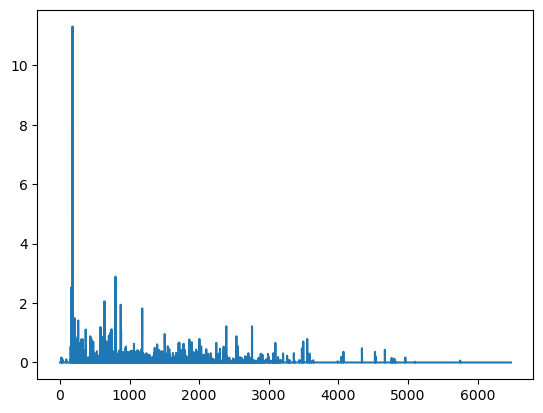

In [23]:
print(in_data.shape)
plt.plot(in_data.cpu().numpy()[3,:])

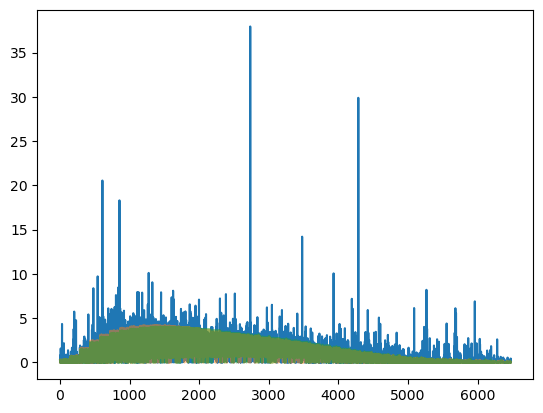

In [24]:
with torch.no_grad():
    in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    # if reducedata:
        # in_data = engine._reduce(in_data, true_energy, R=R)
    fwd_output = engine.model((in_data, true_energy), True)
    engine._model.sampler._batch_size = true_energy.shape[0]
    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
idx = 12
plt.plot(in_data.cpu().numpy()[idx,:])
plt.plot(fwd_output.output_activations.detach().cpu().numpy()[idx,:], alpha=0.5)
plt.plot(sample_data.detach().cpu().numpy()[idx,:], alpha=0.5)

In [46]:
# enIn = torch.cat((in_data, true_energy), dim=1)
# beta, post_logits, post_samples = engine.model.encoder(enIn)
with torch.no_grad():
    # enIn = torch.cat((in_data, true_energy), dim=1)
    # beta, post_logits, post_samples = engine.model.encoder(enIn)
    beta, post_logits, post_samples = engine.model.encoder(in_data, true_energy)
# plt.plot(post_samples[0][0,:].detach().cpu().numpy())
post_samples = torch.cat(post_samples, 1)

In [21]:
# t0 = time.time() outputs = net(x) torch.cuda.current_stream().synchronize() t1 = time.time()

decoder_time = []
for i in range(500):
    # start = time.process_time()
    start = time.time()
    output_hits, output_activations = engine.model.decoder(post_samples, true_energy)
    torch.cuda.current_stream().synchronize()
    t1 = time.time()
    decoder_time.append(t1 - start)
    # decoder_time.append(time.process_time() - start)

In [22]:
print(np.mean(decoder_time), np.std(decoder_time))

0.010469470977783203 0.0005546670617905547


Text(0, 0.5, 'decoder time (s)')

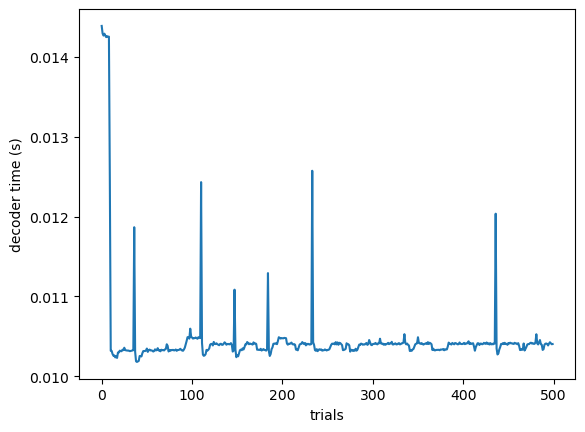

In [23]:
plt.plot(decoder_time)
plt.xlabel("trials")
plt.ylabel("decoder time (s)")

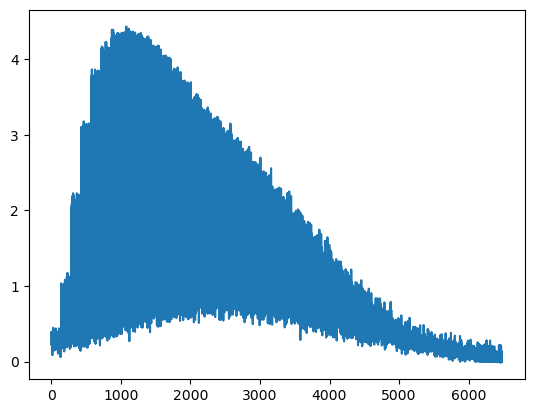

In [27]:
# post_samples = torch.cat([post_samples, true_energy], dim=1)
# post_samples = torch.cat(post_samples,1)
# output_hits, output_activations = engine.model.decoder(post_samples)
output_hits, output_activations = engine.model.decoder(post_samples, true_energy)
plt.plot(output_activations[idx,:].detach().cpu().numpy())


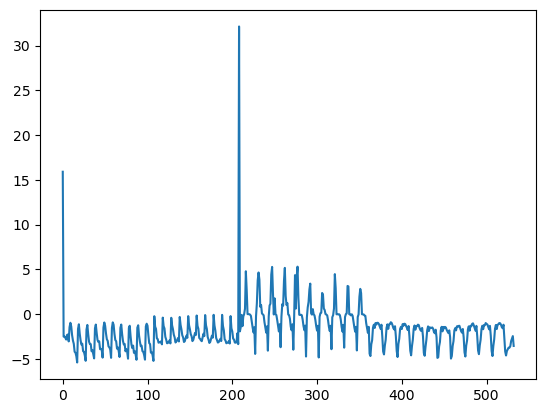

In [26]:
# self._hit_smoothing_dist_mod(output_hits, beta, is_training)
plt.plot(output_hits[1,:].detach().cpu().numpy())
beta = torch.tensor(5, dtype=torch.float, device=output_hits.device, requires_grad=False)

In [68]:
beta = torch.tensor(1, dtype=torch.float, device=output_hits.device, requires_grad=False)

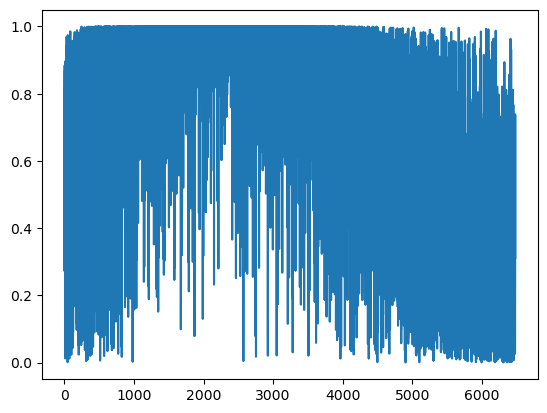

In [69]:
plt.plot(engine.model._hit_smoothing_dist_mod(output_hits, beta, True)[2,:].detach().cpu().numpy())

In [29]:
weight_dict = engine.model.prior.weight_dict

In [30]:
(weight_dict['01']==0).sum()

tensor(259267, device='cuda:0')

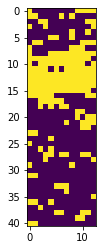

In [30]:
# engine.model._hit_smoothing_dist_mod(output_hits, torch.Tensor([5]), is_training=False)[idx,:].detach().cpu()
idx=5
# plt.imshow(torch.where(in_data > 0, 1., 0.)[idx,:].detach().cpu().numpy().reshape(23,16))
plt.imshow(torch.where(in_data > 0, 1., 0.)[idx,:].detach().cpu().numpy().reshape(41,13))

In [61]:
# fwd_output.output_activations.shape

In [554]:
(output_hits.sum(dim=0) == 0).sum()
engine._config.model.output_smoothing_fct

# engine.model._energy_activation_fct
beta = torch.tensor(engine._config.model.output_smoothing_fct, dtype=torch.float, device=output_hits.device, requires_grad=False)
output = engine.model._energy_activation_fct(output_activations) * engine.model._hit_smoothing_dist_mod(output_hits, beta, False)
o1 = engine.model._energy_activation_fct(output_activations)
o2 = engine.model._hit_smoothing_dist_mod(output_hits, beta, False)

In [555]:
(output.sum(dim=0) == 0).sum()
(o1.sum(dim=0) == 0).sum()
# (o2.sum(dim=0) == 0).sum()
# (in_data.sum(dim=0) == 0).sum()
# in_data.shape
# engine.model._energy_activation_fct

tensor(0, device='cuda:0')

In [27]:
directory_path = f'/home/javier/Projects/CaloQVAE/figs/{modelname}'
if not os.path.isdir(directory_path):
    os.mkdir(directory_path) 
else:
    pass

In [40]:
beta, beta_list, rbm_energy_list, dwave_energies_list = engine.model.find_beta(10.0, 0.01, 30)

Epoch 0: beta = 10.0
Epoch 1: beta = 9.549627532958985
Epoch 2: beta = 9.16130401611328
Epoch 3: beta = 8.842587585449218
Epoch 4: beta = 8.561137008666991
Epoch 5: beta = 8.290790939331053
Epoch 6: beta = 8.057470245361326
Epoch 7: beta = 7.845232696533201
Epoch 8: beta = 7.6526835632324195
Epoch 9: beta = 7.474332351684568
Epoch 10: beta = 7.312869186401365
Epoch 11: beta = 7.18781929016113
Epoch 12: beta = 7.069037017822263
Epoch 13: beta = 6.979260025024411
Epoch 14: beta = 6.905738830566404
Epoch 15: beta = 6.849734115600583
Epoch 16: beta = 6.819763031005857
Epoch 17: beta = 6.80673042297363
Epoch 18: beta = 6.785146865844724
Epoch 19: beta = 6.783003845214841
Epoch 20: beta = 6.840853500366208
Epoch 21: beta = 6.913841476440427
Epoch 22: beta = 6.9827844238281225
Epoch 23: beta = 7.059679183959958
Epoch 24: beta = 7.079130249023435
Epoch 25: beta = 7.073467178344724
Epoch 26: beta = 7.043541336059568
Epoch 27: beta = 7.013037109374998
Epoch 28: beta = 6.979190826416013
Epoch 29:

In [16]:
engine.model._qpu_sampler.properties["chip_id"]

'Advantage_system6.3'

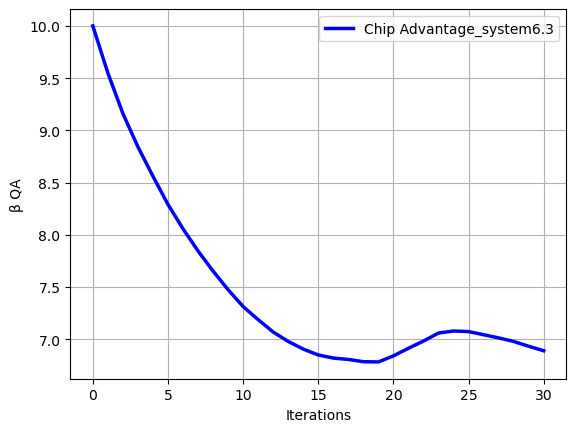

In [41]:
plt.plot(beta_list, linewidth=2.5, color="b" )
plt.xlabel("Iterations")
plt.ylabel("β QA")
plt.legend([f'Chip {engine.model._qpu_sampler.properties["chip_id"]}'])
# plt.title(f'{ds[part]}')
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/beta_QA_{engine.model._qpu_sampler.properties["chip_id"]}_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()
# engine.model.eval();
# (engine.model.prior._weight_dict['01'] == 0).sum(axis=1)

In [42]:
Hoffset = -(sum([engine.model.prior.bias_dict[key].sum().detach().cpu().item() for key in engine.model.prior.bias_dict.keys()])/2 + sum([engine.model.prior.weight_dict[key].sum().detach().cpu().item() for key in engine.model.prior.weight_dict.keys()])/4)


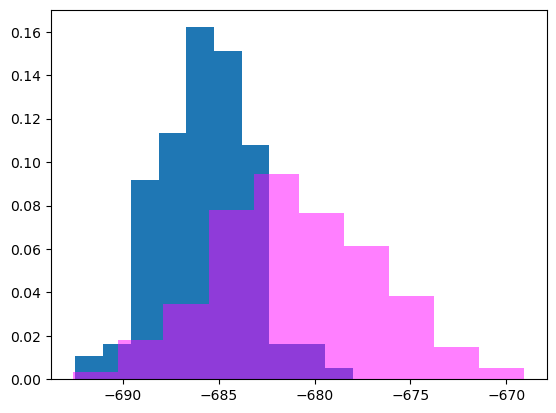

128


In [43]:
plt.hist(rbm_energy_list[-1] + Hoffset, density=True)
plt.hist(dwave_energies_list[-1] + Hoffset, density=True, fc=(1, 0, 1, 0.5))
plt.show()
print(len(rbm_energy_list[-1]))

In [67]:
# Encoded data and RBM

In [106]:

partition_size=512
encoded_data = []
energy_encoded_data = []

encoded_data_rdm = []
energy_encoded_data_rdm = []
engine.model.eval()
engine_2.model.eval()
with torch.no_grad():
    for xx in val_loader:
    # for xx in train_loader:
        in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
        if reducedata:
            in_data = engine._reduce(in_data, true_energy, R=R)
        # enIn = torch.cat((in_data, true_energy), dim=1)
        # beta, post_logits, post_samples = engine.model.encoder(enIn, False)
        beta, post_logits, post_samples = engine.model.encoder(in_data, true_energy, False)
        post_samples = torch.cat(post_samples, 1)
        post_samples_energy = engine.model.stater.energy_samples(post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], 
                                                 post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size], 1.0 )
        encoded_data.append(post_samples.detach().cpu())
        energy_encoded_data.append(post_samples_energy.detach().cpu())
        
        #Rdm model
        # enIn = torch.cat((in_data, true_energy), dim=1)
        # beta, post_logits, post_samples = engine.model.encoder(enIn, False)
        beta, post_logits, post_samples = engine_2.model.encoder(in_data, true_energy, False)
        post_samples = torch.cat(post_samples, 1)
        post_samples_energy = engine_2.model.stater.energy_samples(post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], 
                                                 post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size], 1.0 )
        encoded_data_rdm.append(post_samples.detach().cpu())
        energy_encoded_data_rdm.append(post_samples_energy.detach().cpu())

encoded_data = torch.cat(encoded_data, dim=0)
energy_encoded_data = torch.cat(energy_encoded_data, dim=0)
        
encoded_data_rdm = torch.cat(encoded_data_rdm, dim=0)
energy_encoded_data_rdm = torch.cat(energy_encoded_data_rdm, dim=0)

p1,p2,p3,p4 = post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], \
                                                 post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size]

energy_rbm_data = []
energy_rbm_rdm_data = []
with torch.no_grad():
    for i in range(10):
        # if i == 0:
            # p1, p2, p3, p4 = engine.model.stater.block_gibbs_sampling_ais(1.0)
        # else:
            # p1, p2, p3, p4 = engine.model.stater.block_gibbs_sampling_ais(1.0, p1, p2, p3, p4)
        p1, p2, p3, p4 = engine.model.sampler.block_gibbs_sampling()
        rbm_samples_energy = engine.model.stater.energy_samples(p1, p2, p3, p4, 1.0)
        energy_rbm_data.append(rbm_samples_energy.detach().cpu())
        
        if i == 0:
            p1_r, p2_r, p3_r, p4_r = engine_2.model.stater.block_gibbs_sampling_ais(1.0)
        else:
            p1_r, p2_r, p3_r, p4_r = engine_2.model.stater.block_gibbs_sampling_ais(1.0, p1_r, p2_r, p3_r, p4_r)
        rbm_rdm_samples_energy = engine_2.model.stater.energy_samples(p1_r, p2_r, p3_r, p4_r, 1.0)
        energy_rbm_rdm_data.append(rbm_rdm_samples_energy.detach().cpu())
    
energy_rbm_data = torch.cat(energy_rbm_data, dim=0)
energy_rbm_rdm_data = torch.cat(energy_rbm_rdm_data, dim=0)

In [107]:
print(-energy_encoded_data.mean() - Zais)
print(-energy_encoded_data_rdm.mean() - Zais_rdm)

tensor(223.8903)
tensor(-2648.0586)


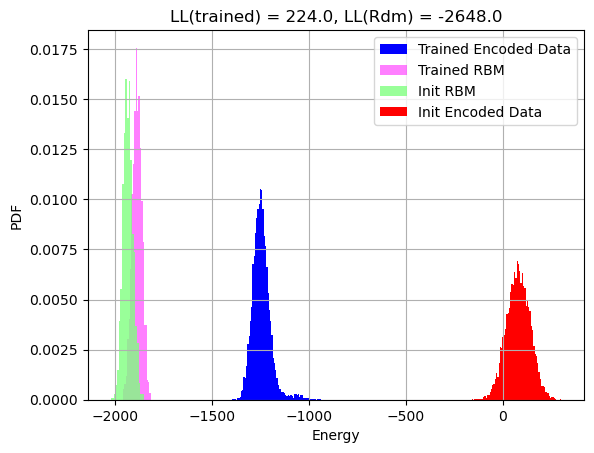

In [108]:
plt.hist(energy_encoded_data.numpy(), bins=70, linewidth=2.5, color="b", density=True)
plt.hist(energy_rbm_data.numpy(), bins=20, linewidth=2.5, color="cyan", density=True, fc=(1, 0, 1, 0.5))
plt.hist(energy_rbm_rdm_data.numpy(), bins=20, linewidth=2.5, color="cyan", density=True, fc=(0.5, 1.0, 0.5, 0.8))

plt.hist(energy_encoded_data_rdm.numpy(), bins=70, linewidth=2.5, color="r", density=True)

plt.xlabel("Energy")
plt.ylabel("PDF")
plt.legend(["Trained Encoded Data", "Trained RBM", "Init RBM", "Init Encoded Data"])
# plt.title(f'ln(Z)[AIS] = {np.round(Zais)}, ln(Z)[RAIS] = {np.round(Zrais)}')
plt.title(f'LL(trained) = {np.round(-energy_encoded_data.mean() - Zais)}, LL(Rdm) = {np.round(-energy_encoded_data_rdm.mean() - Zais_rdm)}')
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/RBM_energy_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [ ]:
# Sparsity and Energy

In [48]:
# en_labels = []

xtarget_samples = []
xrecon_samples = []
xgen_samples = []
xgen_samples_qpu = []

# labelstarget_samples = []
# labelsrecon_samples = []
entarget_samples = []
with torch.no_grad():
    for xx in val_loader:
    # for xx in train_loader:
        in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
        if reducedata:
            in_data = engine._reduce(in_data, true_energy, R=R)
        fwd_output = engine.model((in_data, true_energy), False)
        if reducedata:
            in_data = engine._reduceinv(in_data, true_energy, R=R)
            recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
        elif scaled:
            in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
            recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
            sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
            sample_data_qpu = torch.tensor(engine._data_mgr.inv_transform(sample_data_qpu.detach().cpu().numpy()))
        else:
            in_data = in_data.detach().cpu()*1000
            recon_data = fwd_output.output_activations.detach().cpu()*1000
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
            sample_data = sample_data.detach().cpu()*1000

        # xrecon_samples.append( torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy())) )
    #     if engine._config.engine.cl_lambda:
    #         labelsrecon_samples.append(fwd_output.labels.detach().cpu())
    #         labelstarget_samples.append( nn.functional.one_hot(true_energy.divide(256).log2().to(torch.int64), num_classes=15).squeeze(1).to(torch.float).detach().cpu() )

    #         en_labels.append(true_energy.detach().cpu())

        xtarget_samples.append(in_data.detach().cpu())
        xrecon_samples.append( recon_data.detach().cpu())
        xgen_samples.append( sample_data.detach().cpu())
        xgen_samples_qpu.append( sample_data_qpu.detach().cpu())
        entarget_samples.append(true_energy.detach().cpu())

        # xtarget_samples.append( torch.tensor(engine._data_mgr.inv_transform(xx[0][0].detach().cpu().numpy())) )
    
    
xtarget_samples = torch.cat(xtarget_samples, dim=0)
xrecon_samples = torch.cat(xrecon_samples, dim=0)
xgen_samples = torch.cat(xgen_samples, dim=0)
xgen_samples_qpu = torch.cat(xgen_samples_qpu, dim=0)
entarget_samples = torch.cat(entarget_samples, dim=0)

# if engine._config.engine.cl_lambda:
#     labelstarget_samples = torch.cat(labelstarget_samples, dim=0)
#     labelsrecon_samples = torch.cat(labelsrecon_samples, dim=0)
#     en_labels = torch.cat(en_labels, dim=0)

#     lhat = torch.argmax(nn.Sigmoid()(labelsrecon_samples), dim=1).numpy()
#     l = torch.argmax(labelstarget_samples, dim=1).numpy()


In [43]:
(xgen_samples.sum(dim=0) == 0).sum()
(xrecon_samples.sum(dim=0) == 0).sum()
# (xtarget_samples.sum(dim=0) == 0).sum()
# print((xgen_samples.sum(dim=0) == 0).nonzero(as_tuple=True))
# print((xrecon_samples.sum(dim=0) == 0).nonzero(as_tuple=True))

tensor(16)

In [22]:
# # Each API call uses ~0.28% of Monthly Access
# engine._model.sampler._batch_size = true_energy.shape[0]
# sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy)
# sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
# engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
2190/180

12.166666666666666

In [22]:
print("mean qpu time", np.mean([engine._model.sampling_time_qpu[i][0] for i in range(9)]), np.std([engine._model.sampling_time_qpu[i][0] for i in range(9)]))
print("mean gpu time", np.mean([engine._model.sampling_time_gpu[i][0] for i in range(9)]), np.std([engine._model.sampling_time_gpu[i][0] for i in range(9)]))
print("mean gpu time/mean qpu time", np.mean([engine._model.sampling_time_gpu[i][0] for i in range(9)])/np.mean([engine._model.sampling_time_qpu[i][0] for i in range(9)]))


mean qpu time 0.07609847550176913 0.0015022773701042905
mean gpu time 2.0308878699110613 0.01634824490215739
mean gpu time/mean qpu time 26.68762884565076


In [119]:
# plt.hist(sample_energies.sum(dim=1).detach().cpu().numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="b")
# plt.hist(sample_energies_qpu.sum(dim=1).detach().cpu().numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")

In [160]:
THRSH=0
xrecon_samples = xrecon_samples * (xrecon_samples > THRSH)
xgen_samples = xgen_samples * (xgen_samples > THRSH)

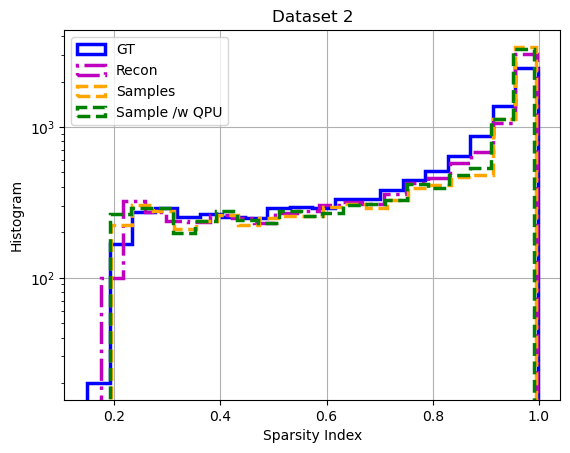

In [49]:
plt.hist(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="b")
plt.hist(((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
plt.hist(((xgen_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
plt.hist(((xgen_samples_qpu == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="green", linestyle="dashed")
plt.xlabel("Sparsity Index")
plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Samples", "Sample /w QPU"])
plt.title(f'{ds[part]}')
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sparsity_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [36]:
# idxPrev = 0
# # for i,idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
# for i, idx in enumerate([16*9*i for i in range(1,5)]):
# # for i,idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
#     l = idx - idxPrev
#     print('Layer ', i, l, ' voxels')
#     plt.hist(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step')
#     plt.hist(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step')
#     plt.hist(((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step')
#     plt.xlabel("Sparsity Index")
#     plt.ylabel("Histogram")
#     plt.legend(["GT", "Recon", "Sample"])
#     plt.title(f'{part} Layer {i}')
#     # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/sparsity_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
#     plt.show()
#     idxPrev = idx

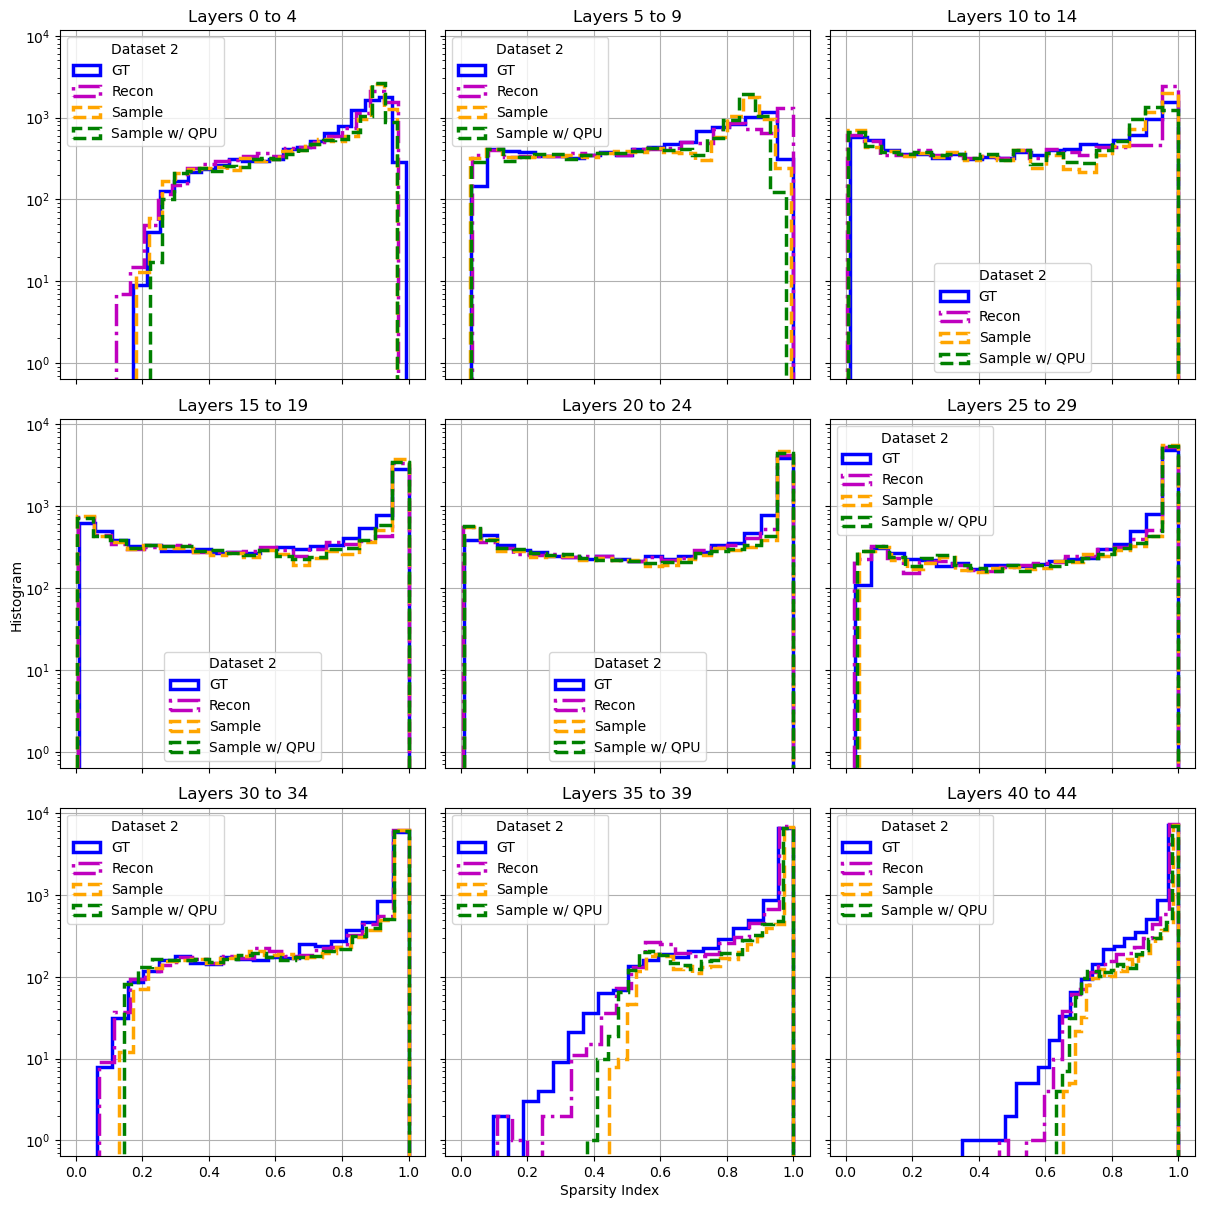

In [50]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=True, tight_layout=True)
fig.text(0.5, 0.0, 'Sparsity Index', ha='center')
fig.text(0.0, 0.5, 'Histogram', va='center', rotation='vertical')

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    ax.hist(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(),  bins=20, log=True, histtype='step', linewidth=2.5, color="b")
    ax.hist(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
    ax.hist(((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
    ax.hist(((xgen_samples_qpu[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="green", linestyle="dashed")
    ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], title=f'{ds[part]}')
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}')

# Adjust layout and display the plots
plt.tight_layout()
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sparsity_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()


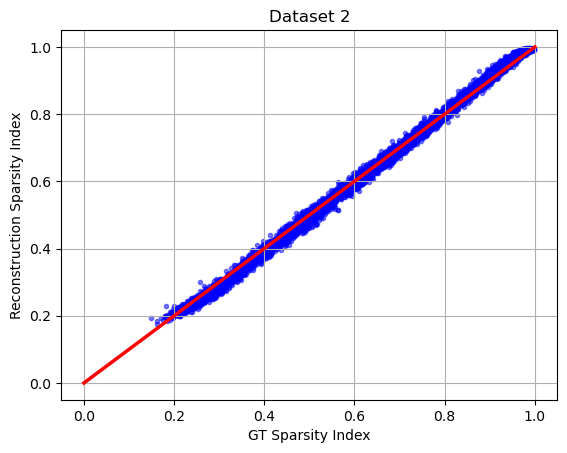

In [51]:
plt.scatter(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), ((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(),  marker='.', alpha=.5, color="b")
plt.plot([0,1],[0,1], c='red', lw=2.5)
plt.xlabel('GT Sparsity Index')
plt.ylabel('Reconstruction Sparsity Index')
plt.title(f'{ds[part]}')
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sparsity_scatter_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [49]:
# idxPrev = 0
# for i, idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
# # for i, idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
#     l = idx - idxPrev
#     print('Layer ', i, l, ' voxels')
#     plt.scatter(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), ((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), marker='.', alpha=.2)
#     plt.plot([0,1],[0,1], c='red', lw=2)
#     plt.xlabel('sparsity index input')
#     plt.ylabel('sparsity index recon')
#     plt.title(f'{part}')
#     # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/sparsity_scatter_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
#     plt.show()
#     idxPrev = idx

In [52]:
E_right = 5000
E_left = 2000
tmp = (entarget_samples < E_right) * (entarget_samples > E_left)
idxEnFilter = (tmp == True).nonzero(as_tuple=True)[0]
len(idxEnFilter)

1410

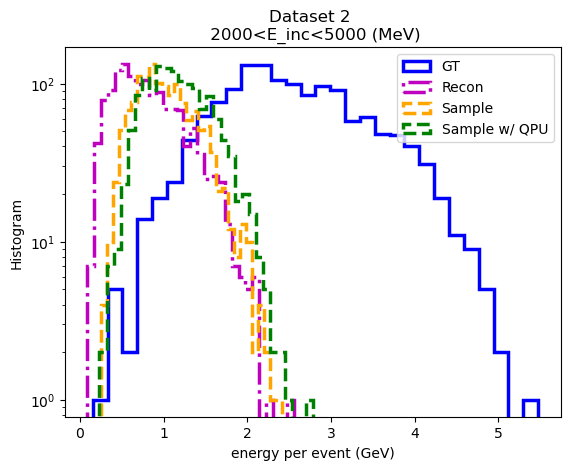

In [53]:
plt.hist(xtarget_samples[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="b")
plt.hist(xrecon_samples[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
plt.hist(xgen_samples[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
plt.hist(xgen_samples_qpu[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="green", linestyle="dashed")

plt.xlabel("energy per event (GeV)")
# plt.xscale('log')

plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Sample", "Sample w/ QPU"])
plt.title(f'{ds[part]} \n {E_left}<E_inc<{E_right} (MeV)')
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_slice_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

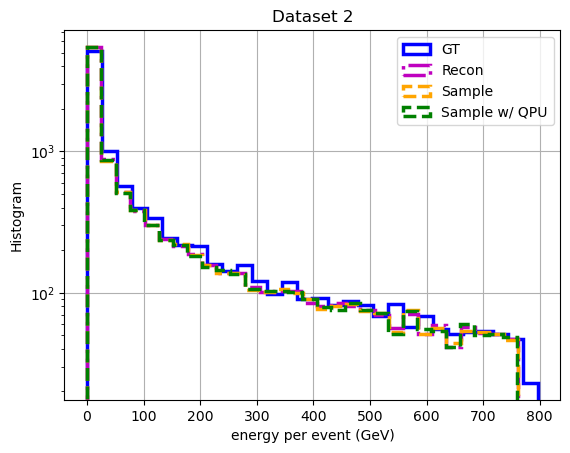

In [54]:
plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="b")
plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="m", linestyle="dashdot")
plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="orange", linestyle="dashed")
plt.hist(xgen_samples_qpu.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="green", linestyle="dashed")
# plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step', linewidth=2.5, color="b")
# plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
# plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
# plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
# plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
# plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
plt.xlabel("energy per event (GeV)")
# plt.xscale('log')

plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Sample", "Sample w/ QPU"])
plt.title(f'{ds[part]}')
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

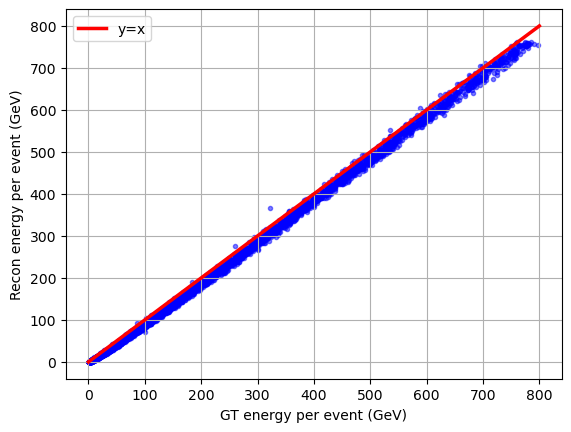

In [55]:
plt.scatter(xtarget_samples.sum(dim=1).numpy()/1000, xrecon_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.5, color="b")
plt.plot([0,800],[0,800], c='red', lw=2.5, label='y=x')
# plt.plot([0,20],[0,20], c='red', lw=2)
# axes[0,1].set_xlabel("GT energy per event (GeV)")
plt.legend()
plt.grid("True")
plt.xlabel("GT energy per event (GeV)")
plt.ylabel("Recon energy per event (GeV)")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_scatter_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

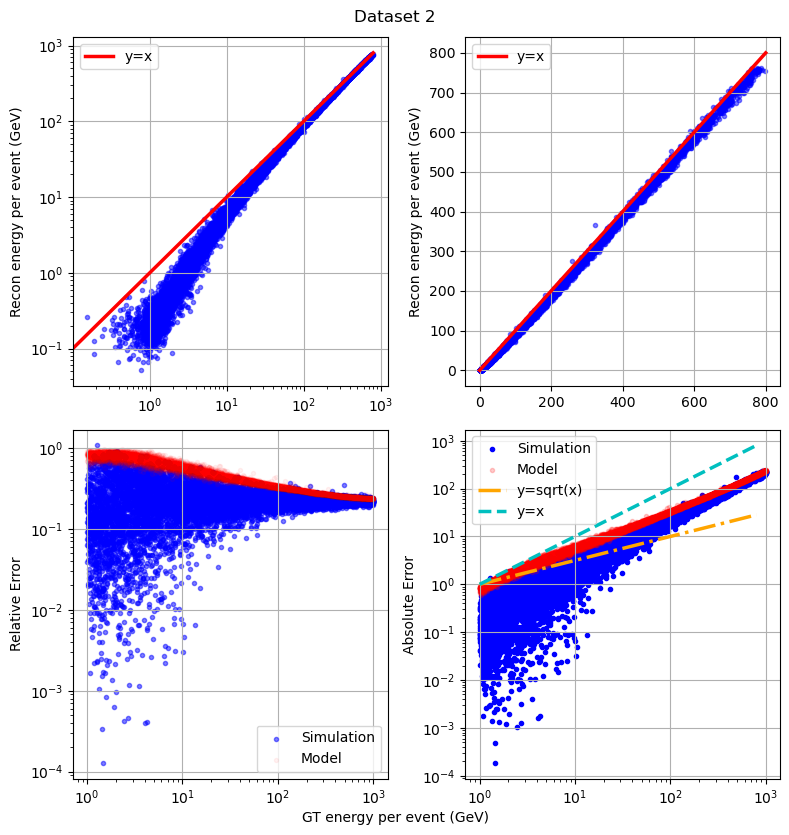

In [56]:
fig, axes = plt.subplots(2,2, figsize=(8,8), tight_layout=True)
fig.text(0.5, 0.0, 'GT energy per event (GeV)', ha='center')
fig.text(0.5, 1.0, f'{ds[part]}', ha='center', fontsize=12)

axes[0,0].scatter(xtarget_samples.sum(dim=1).numpy()/1000, xrecon_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.5, color="b")
axes[0,0].plot([0,800],[0,800], c='red', lw=2.5, label='y=x')
# axes[0,0].plot([0,3800],[0,3800], c='red', lw=2.5, label='y=x')
axes[0,0].set_ylabel("Recon energy per event (GeV)")
axes[0,0].legend()
axes[0,0].grid("True")
axes[0,0].set_yscale('log')
axes[0,0].set_xscale('log')

axes[0,1].scatter(xtarget_samples.sum(dim=1).numpy()/1000, xrecon_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.5, color="b")
axes[0,1].plot([0,800],[0,800], c='red', lw=2.5, label='y=x')
# axes[0,1].plot([0,3800],[0,3800], c='red', lw=2.5, label='y=x')
# plt.plot([0,20],[0,20], c='red', lw=2)
# axes[0,1].set_xlabel("GT energy per event (GeV)")
axes[0,1].set_ylabel("Recon energy per event (GeV)")
axes[0,1].legend()
axes[0,1].grid("True")

# axes[1,0].scatter(xtarget_samples.sum(dim=1).numpy()/1000, np.abs(xtarget_samples.sum(dim=1).numpy() - xrecon_samples.sum(dim=1).numpy())/(xtarget_samples.sum(dim=1).numpy()+1e-3), marker='.', alpha=.5, color="blue")
axes[1,0].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy() - xtarget_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.5, color="blue", label="Simulation")
axes[1,0].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy() - xrecon_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.05, color="red", label="Model")
# axes[1,0].set_title(f'{ds[part]}')
axes[1,0].grid("True")
axes[1,0].set_yscale('log')
axes[1,0].set_xscale('log')
axes[1,0].legend()
axes[1,0].set_ylabel("Relative Error")

# axes[1,1].scatter(xtarget_samples.sum(dim=1).numpy()/1000, np.abs(xtarget_samples.sum(dim=1).numpy()/1000 - xrecon_samples.sum(dim=1).numpy()/1000), marker='.', alpha=.5, color="blue")
axes[1,1].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy()/1000 - xtarget_samples.sum(dim=1).numpy()/1000), marker='.', alpha=1, color="blue", label="Simulation")
axes[1,1].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy()/1000 - xrecon_samples.sum(dim=1).numpy()/1000), marker='.', alpha=.2, color="red", label="Model")
axes[1,1].plot([1,800],np.sqrt([1,800]), c='orange', lw=2.5, label='y=sqrt(x)', linestyle="dashdot")
axes[1,1].plot([1,800],[1,800], c='c', lw=2.5, label='y=x', linestyle="dashed")
# axes[1,1].set_title(f'{ds[part]}')
axes[1,1].grid("True")
axes[1,1].set_yscale('log')
axes[1,1].set_xscale('log')
axes[1,1].set_ylabel("Absolute Error")
axes[1,1].legend()
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_scatter_4panels_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [159]:
# entarget_samples.reshape(-1)
xtarget_samples.sum(dim=1).shape

torch.Size([10000])

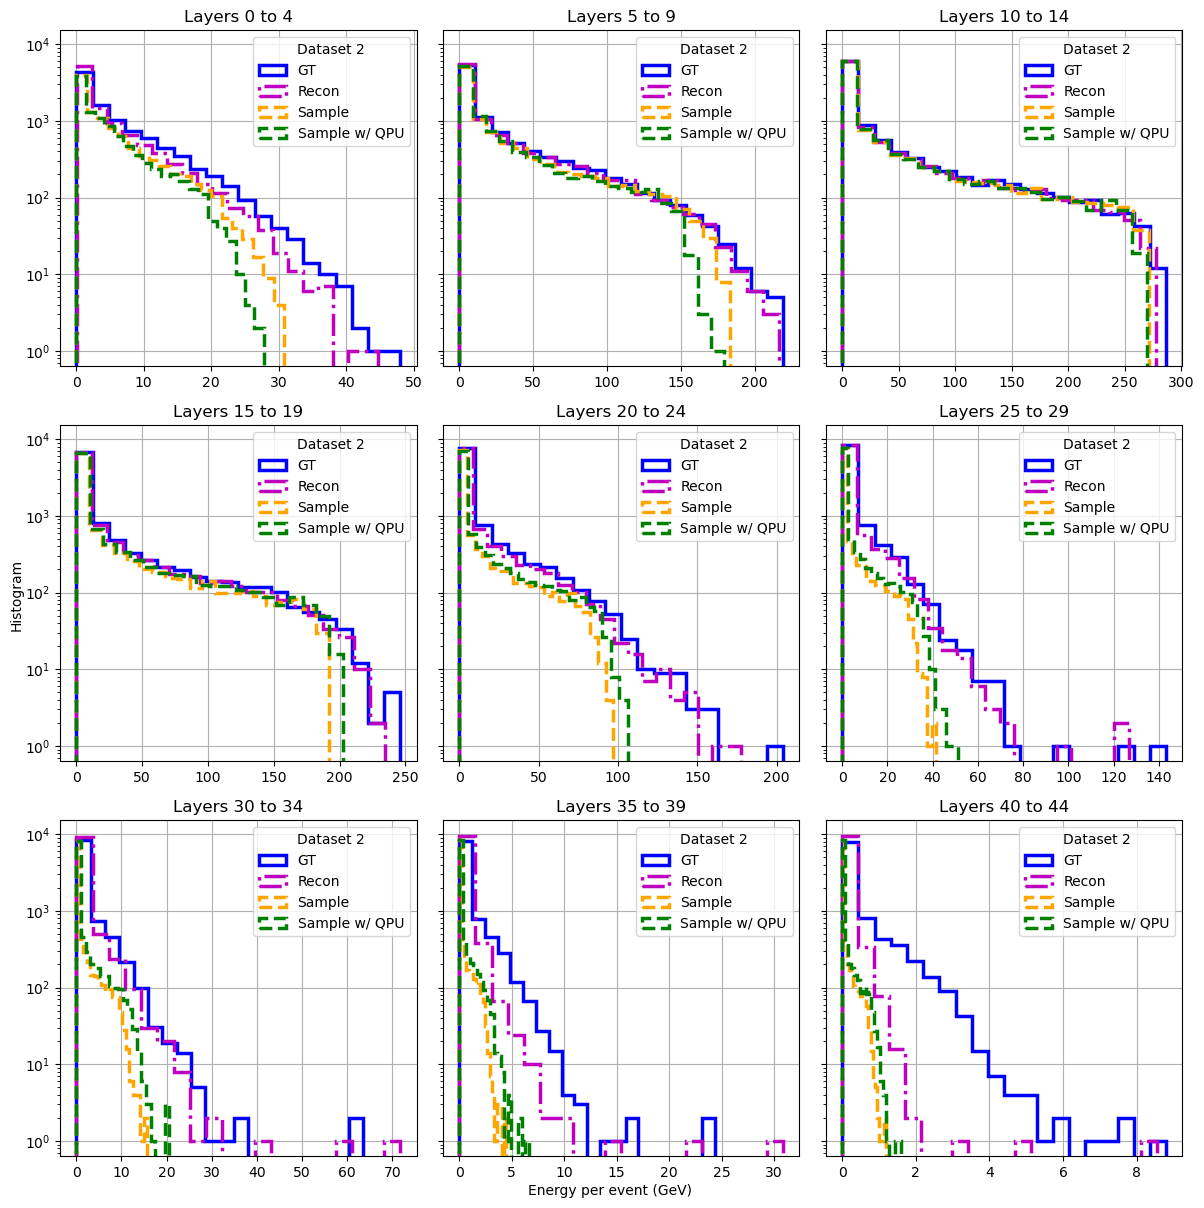

In [57]:
# HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=False, tight_layout=True)
fig.text(0.5, 0.0, 'Energy per event (GeV)', ha='center')
fig.text(0.0, 0.5, 'Histogram', va='center', rotation='vertical')

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    ax.hist(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000,  bins=20, log=True, histtype='step', linewidth=2.5, color="b")
    ax.hist(xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
    ax.hist(xgen_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
    ax.hist(xgen_samples_qpu[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="green", linestyle="dashed")
    ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], title=f'{ds[part]}')
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}')

# Adjust layout and display the plots
plt.tight_layout()
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()


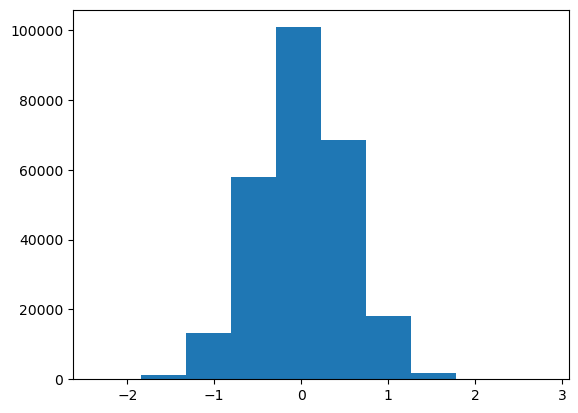

In [42]:
# plt.hist(engine._model.prior._weight_dict['23'].reshape(-1).detach().cpu().numpy())
# plt.show()
# engine._model.prior._weight_dict['01'].reshape(-1)

In [368]:
# idxPrev = 0
# # for i, idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
# for i, idx in enumerate([16*9*i for i in range(10,20)]):
# # for i, idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
#     l = idx - idxPrev
#     print('Layer ', i, l, ' voxels')
#     plt.scatter(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, marker='.', alpha=.2)
#     plt.plot([0,xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy().max()/1000],[0,xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy().max()/1000], c='red', lw=2)
    
#     plt.xlabel("input energy per event (GeV)")
#     plt.ylabel("recon energy per event (GeV)")
#     plt.title(f'{part}')
#     # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/energy_scatter_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
#     plt.show()
#     idxPrev = idx

In [151]:
np.unique(HLF_1_pions.bin_edges)

array([  0,   8, 108, 208, 213, 363, 523, 533])

In [153]:
xx = next(iter(val_loader))
in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1]) # input , label

In [35]:
if reducedata:
    in_data = engine._reduce(in_data, true_energy, R=R)
fwd_output = engine.model((in_data, true_energy), False)
if reducedata:
    in_data = engine._reduceinv(in_data, true_energy, R=R)
    recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
    engine._model.sampler._batch_size = true_energy.shape[0]
    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
    sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
elif scaled:
    in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
    recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
    engine._model.sampler._batch_size = true_energy.shape[0]
    # try:
    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    # except:
        # pass
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
    # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
    sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
else:
    in_data = in_data.detach().cpu()*1000
    recon_data = fwd_output.output_activations.detach().cpu()*1000
    engine._model.sampler._batch_size = true_energy.shape[0]
    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
    # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
    sample_data = sample_data.detach().cpu()*1000

In [303]:
THRSH=7
recon_data = recon_data * (recon_data > THRSH)
sample_data = sample_data * (sample_data > THRSH)

In [44]:
HLF_1_pions.relevantLayers = [1,2,3,4,5,6,7]

In [121]:
HLF_1_electron.relevantLayers = [5,10,15,30,35]

In [45]:
# (((in_data[:,0:108] - recon_data[:,0:108])/(in_data[:,0:108]))**2).sum(dim=1).argsort()[:20]
(((in_data - recon_data)/(in_data+1e-5))**2).sum(dim=1).argsort()[-200:-1]
# (((in_data - recon_data))**2).sum(dim=1).argsort()[:20]

tensor([779, 684, 113, 335, 110, 119, 395, 151,  22, 171, 144, 709, 660, 313,
        298, 627, 109, 769, 189, 380, 214, 292, 404, 183, 410, 271, 149, 405,
        447, 653, 437, 334, 129, 289, 168,  36,  81,   4, 184, 143, 101, 159,
        629, 590, 284, 158, 435, 247, 757,  94, 729, 723, 181, 551, 642, 282,
          6, 316, 549, 391, 566, 702, 640, 496, 414, 486, 632, 136, 368, 643,
        767,  37,  75, 373, 553, 117, 630, 515,  27, 114, 196, 393, 658,  16,
        425,  93, 192, 349, 120, 178, 633, 616, 375,  96, 255, 204, 649,   2,
        154, 442, 164, 319, 300, 558, 215, 563, 736, 295, 253, 412,  39, 562,
        489, 501, 595, 721,  47, 205, 264, 753, 423, 720, 493,  59, 497, 461,
        661, 396, 417,  21, 523, 325, 297, 524, 186, 399, 663, 738, 195,  31,
        719, 507, 420, 418, 311, 288, 708, 116, 141, 536, 579, 140, 760, 754,
        452, 554, 198, 732, 145, 361, 366, 625,  83,  90, 619, 254, 468, 540,
        281, 727, 559, 212, 274,  14, 714, 752, 699, 219, 781, 3

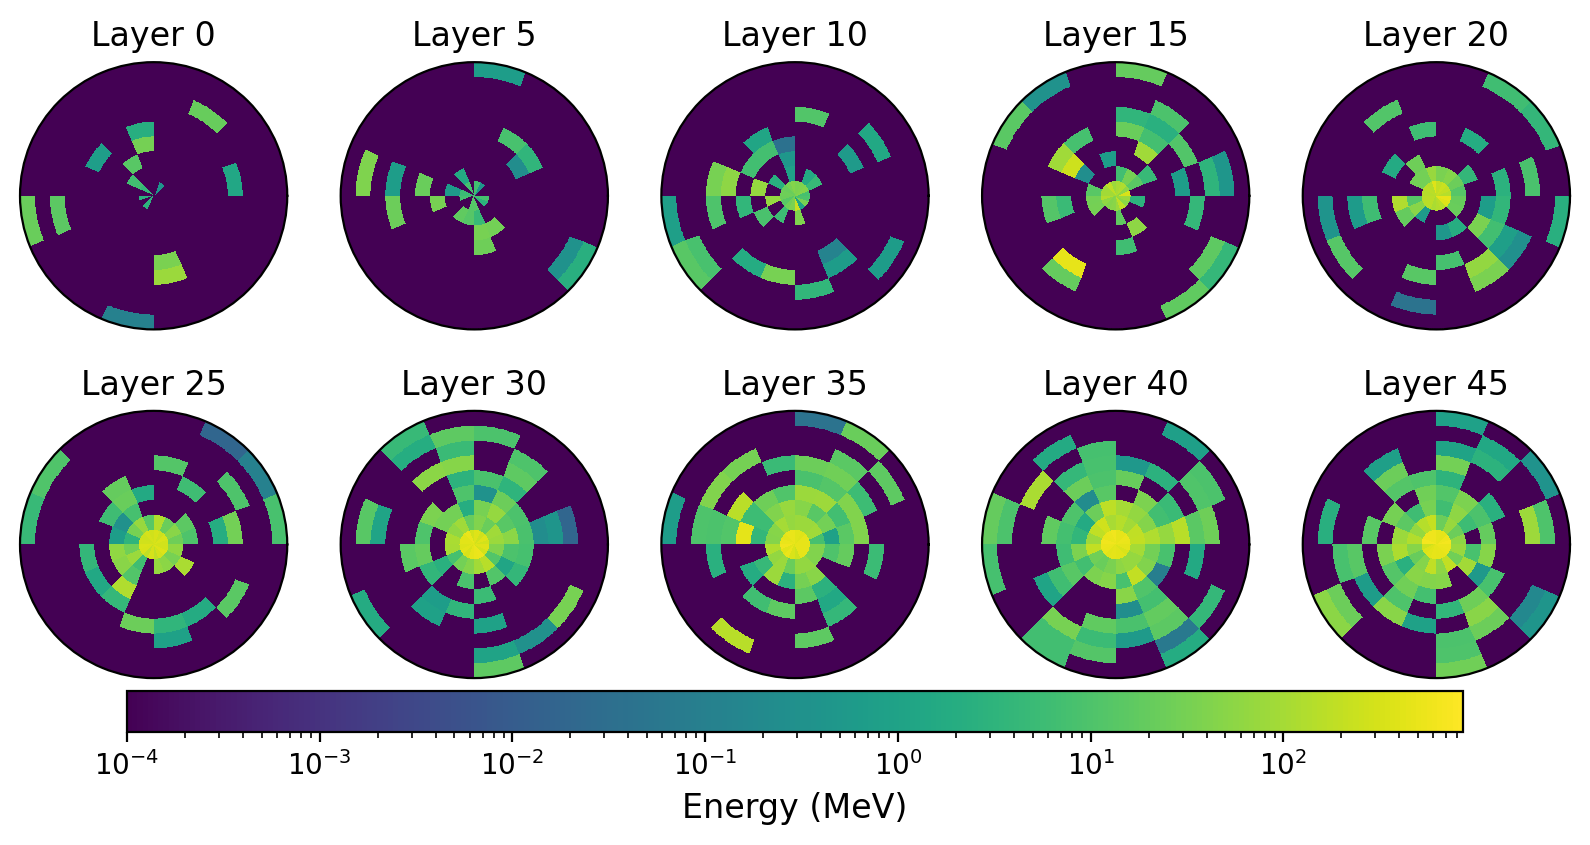

In [50]:
idx=779
# HLF_1_pions.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), filename=None)
# HLF_1_pions.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/target_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')

HLF_1_electron.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/target_a_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), filename=None)


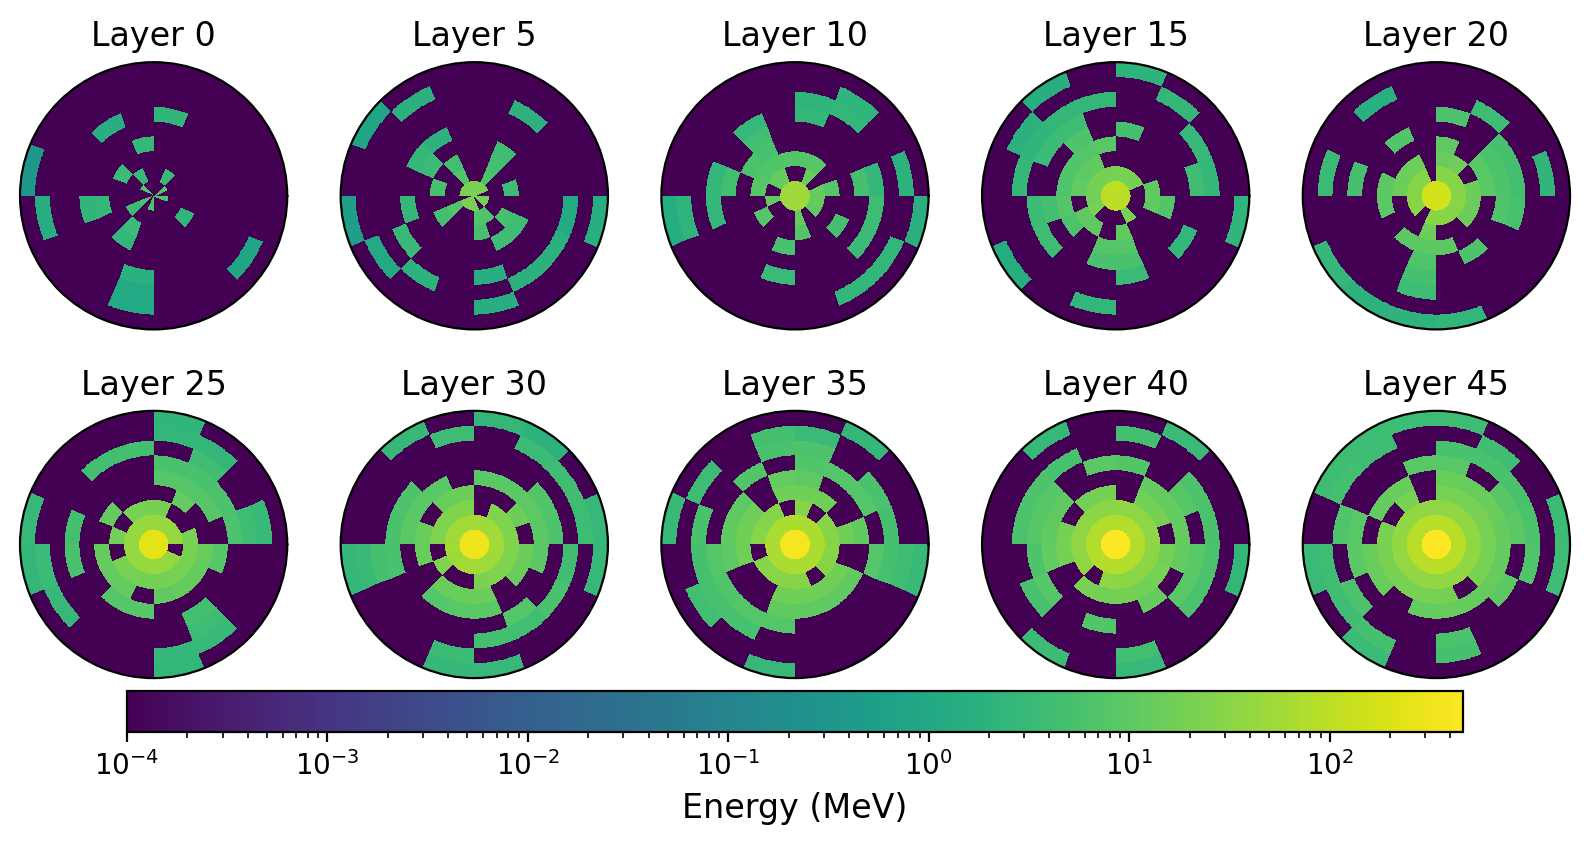

In [51]:
# HLF_1_pions.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), filename=None)
# HLF_1_pions.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/recon_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')

HLF_1_electron.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/recon_a_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), filename=None)

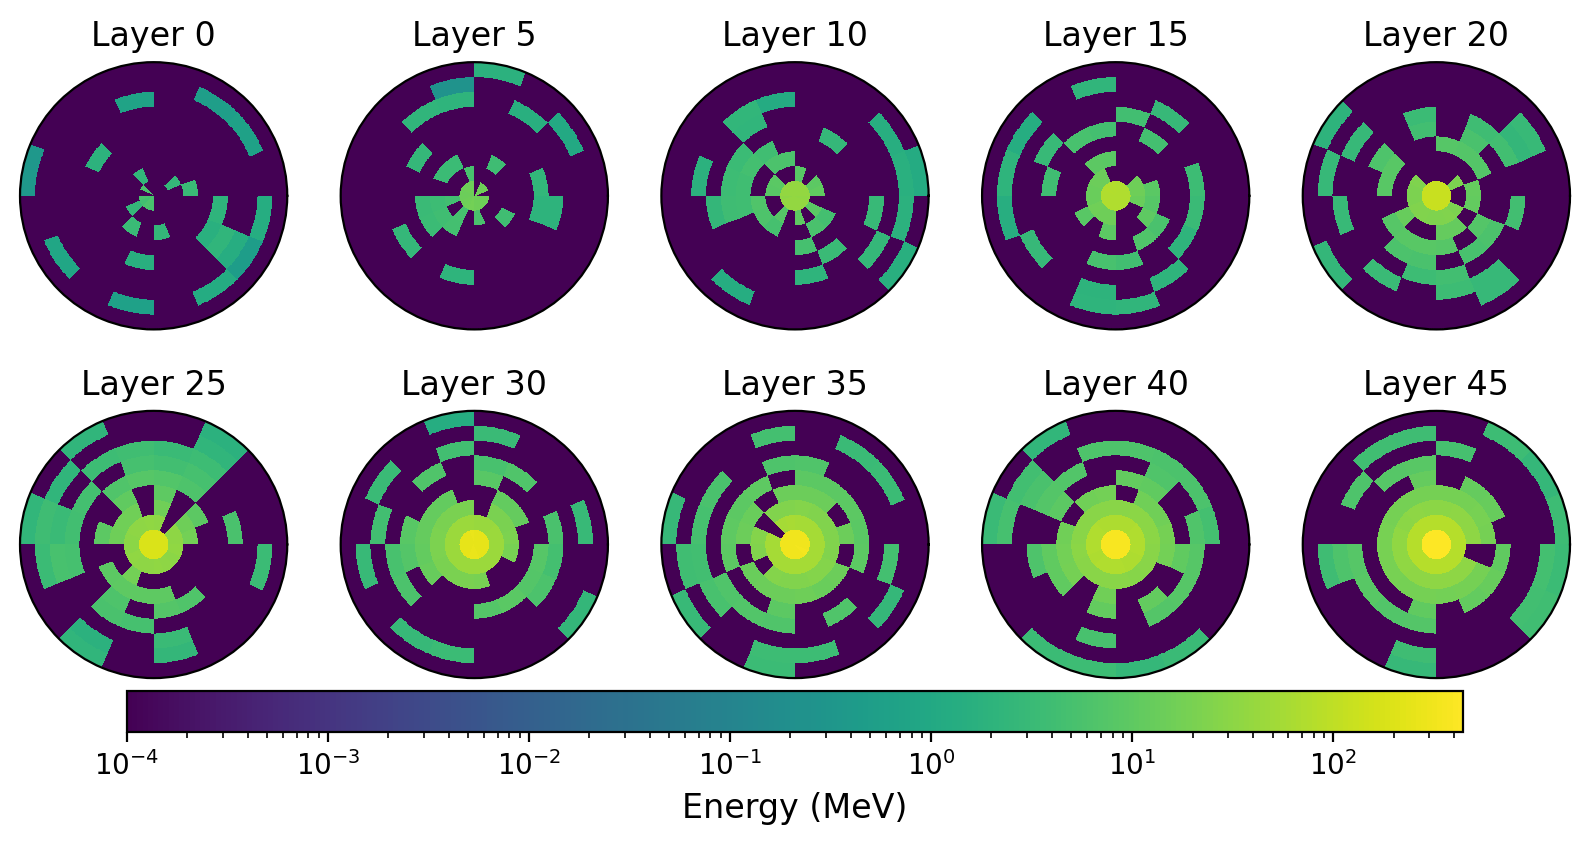

In [52]:
# HLF_1_pions.DrawSingleShower(sample_data[idx,:].detach().cpu().numpy(), filename=None)
# HLF_1_pions.DrawSingleShower(sample_data[1,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sample_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')

HLF_1_electron.DrawSingleShower(sample_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sample_a_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(sample_data[idx,:].detach().cpu().numpy(), filename=None)

In [103]:
# HLF_1_electron.DrawSingleShower(sample_data_qpu[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sample_QPU_a_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(sample_data_qpu[idx,:].detach().cpu().numpy(), filename=None)

IndexError: index 6480 is out of bounds for dimension 0 with size 784

In [74]:
#Average Shower
modelname

'northern-meadow-223'

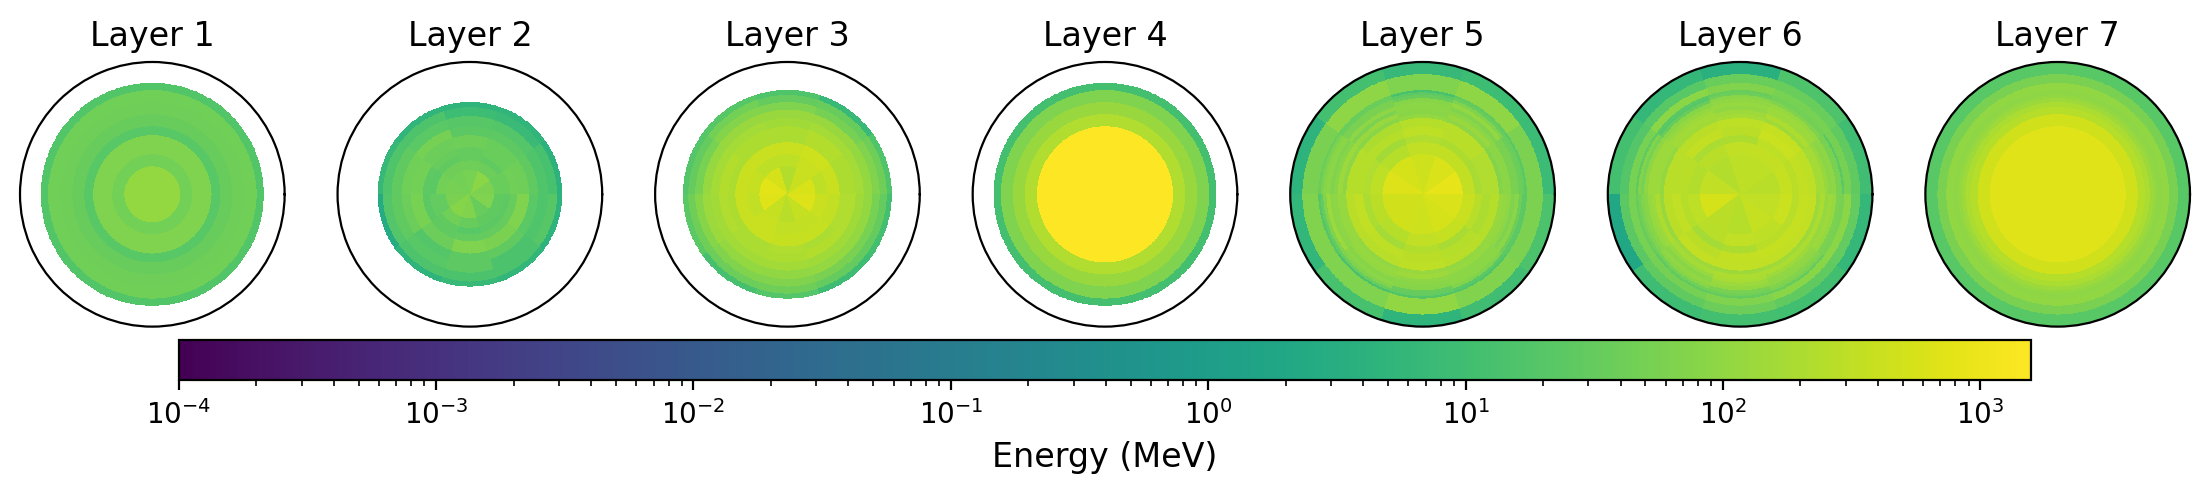

In [636]:
HLF_1_pions.DrawAverageShower(in_data[idx:idx+100,:].detach().cpu().numpy(), filename=None)

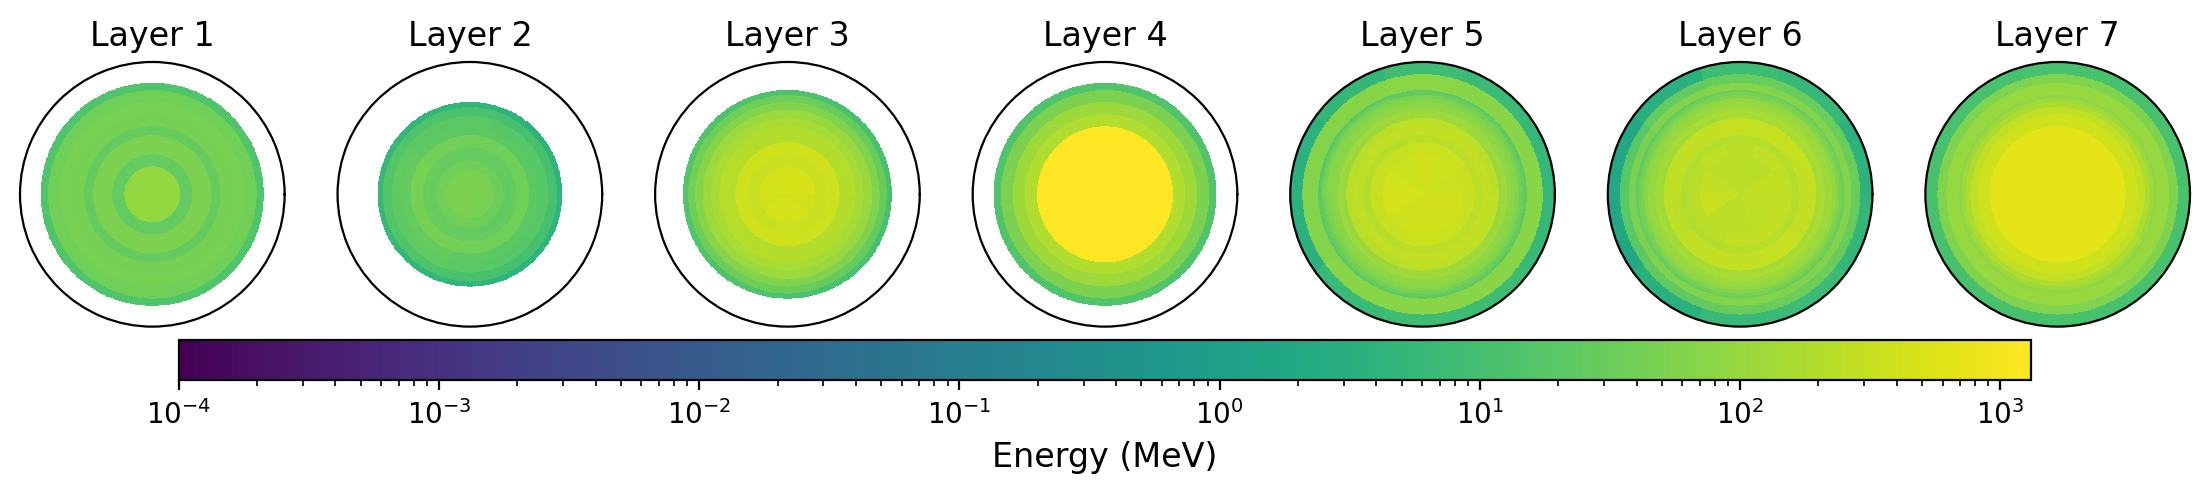

In [637]:
HLF_1_pions.DrawAverageShower(recon_data[idx:idx+100,:].detach().cpu().numpy(), filename=None)

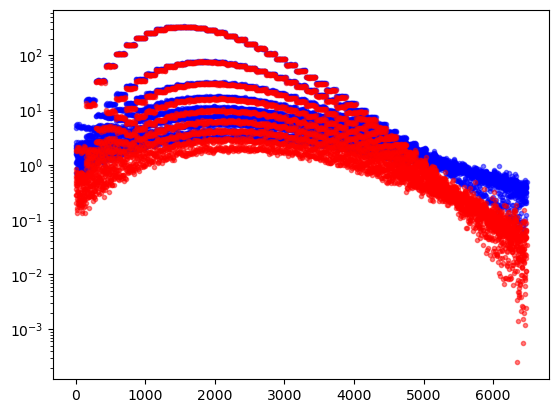

In [104]:
plt.plot(xtarget_samples.mean(dim=0).numpy(), marker='.', alpha=.5, color="b", linewidth=0)
plt.plot(xrecon_samples.mean(dim=0).numpy(), marker='.', alpha=.5, color="r", linewidth=0)
plt.yscale('log')
plt.yscale('log')
plt.show()